<a href="https://colab.research.google.com/github/viscioalj/colab_reference/blob/main/huggingface_wav2vec_whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning or using Whisper, wav2vec2, HuBERT and others with SpeechBrain and <img src="https://huggingface.co/front/assets/huggingface_logo.svg" alt="drawing" width="40"/>   

This tutorial describes how to combine (use and finetune) pretrained models coming from the HuggingFace Transformers library including, for instance, Whisper, wav2vec 2.0, HuBERT, WavLM and others. Those models can be plugged easily into SpeechBrain to approach a speech- or audio-related task: automatic speech recognition, speaker recognition, spoken language understanding ...

**What About Pre-training?**
Pre-training large SSL models is complex for many reasons ranging from necessary resources (dozens of GPUs for hundreds of hours) to replicability issues due to the pipeline. For now, SpeechBrain only provides pre-training of [wav2vec 2.0 models](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/self-supervised-learning/wav2vec2).

**Why SpeechBrain?**
Different and numerous reasons may be mentioned to motivate the use of SpeechBrain. However, in the very specific context of pretrained models, SpeechBrain enables researchers and users to connect these architectures to state-of-the-art speech and audio-related technologies. For instance, SpeechBrain allows you to easily fine-tune a pretrained wav2vec2 model with a transformer decoder coupled with a beam search algorithm and a transformer language model to build a SOTA speech recognizer. It could also help you to simply use the encoder of a pretrained Whisper to perform emotion recognition.To the best of our knowledge, most of other toolkit do not enable you to achieve this. 

**Architectures of interest for this tutorial** 
We will only consider two of the most up-to-date existing pretrained model: wav2vec 2.0 and Whisper. However, SpeechBrain support many others: wavLM, HuBERT ... 

Wav2Vec is a transformer-based encoder architecture enabling self-supervised representation learning of speech. Please refer to the official paper to obtain more details: [wav2vec2](https://arxiv.org/abs/2006.11477).

<img src="https://miro.medium.com/max/2300/0*CdcN0iV_39yEOPeF" alt="drawing" width="700"/>

*Illustration of Wav2vec2, [source](https://medium.com/georgian-impact-blog/how-to-make-an-end-to-end-automatic-speech-recognition-system-with-wav2vec-2-0-dca6f8759920).*

Whisper is a full transformer (encoder-decoder) trained on large amount of semi-supervised data (600k+ hours of speech). Please refer to the official paper to obtain more details: [whisper](https://cdn.openai.com/papers/whisper.pdf)

<img src="https://cdn.openai.com/whisper/asr-summary-of-model-architecture-desktop.svg" alt="drawing" width="700"/>
*Illustration of Whisper, [source](https://openai.com/blog/whisper/).*

**With this tutorial, you will learn how to:**
1. Instantiate a wav2vec2 or a Whisper to extract features from an audio file.
2. Use wav2vec2 and Whisper encoders as a block of your pipeline (ASR, TIMIT).
3. Use Whisper as an encoder-decoder architecture for fine-tuning (ASR, LibriSpeech)
4. Understand current limitations of our integration.


## Prerequisites
- [SpeechBrain Introduction](https://colab.research.google.com/drive/12bg3aUdr9mTfOGqcB5pSMABoIKPgiwcM?usp=sharing)
- [YAML tutorial](https://colab.research.google.com/drive/1Pg9by4b6-8QD2iC0U7Ic3Vxq4GEwEdDz?usp=sharing)
- [Brain Class tutorial](https://colab.research.google.com/drive/1fdqTk4CTXNcrcSVFvaOKzRfLmj4fJfwa?usp=sharing)
- [DataIOBasics](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH)
- [Pretrained Models and Fine-Tuning](https://colab.research.google.com/drive/1LN7R3U3xneDgDRK2gC5MzGkLysCWxuC3?usp=sharing)

## I. Wav2Vec 2.0 and Whisper from <img src="https://huggingface.co/front/assets/huggingface_logo.svg" alt="drawing" width="40"/> 

Wav2vec 2.0 models were originally shared via the [Faiseq GitHub](https://github.com/pytorch/fairseq/blob/master/examples/wav2vec/README.md) and moved very recently to [HuggingFace](https://huggingface.co/facebook) thanks to a nice integration to the HuggingFace [Transformers API](https://huggingface.co/transformers/model_doc/wav2vec2.html). The same thing happened with Whisper model than went from the [original repository](https://github.com/openai/whisper) to the HuggingFace [Transformers API](https://huggingface.co/docs/transformers/model_doc/whisper). Hence, if you want to use a pretrained Transformer model within SpeechBrain you only need a HuggingFace repository! (e.g. "facebook/wav2vec2-large-lv60", "openai/whisper-large" or "microsoft/wavlm-large").

But first, let's install all the needed packages ...




In [ ]:
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install .

Cloning into 'speechbrain'...
remote: Enumerating objects: 57277, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 57277 (delta 220), reused 266 (delta 207), pack-reused 56988
Receiving objects: 100% (57277/57277), 62.47 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (37596/37596), done.
/content/speechbrain
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Ignoring SoundFile: markers 'sys_platform == "win32"' don't match your environment
     |████████████████████████████████| 97 kB 1.9 MB/s 
     |████████████████████████████████| 97 kB 160 kB/s 
     |████████████████████████████████| 69 kB 1.2 MB/s 
     |████████████████████████████████| 51 kB 2.8 MB/s 
     |████████████████████████████████| 246 kB 66.3 MB/s 
     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 182 kB 45.9 MB/s 
     |████████████████████████████████| 199

Install the HuggingFace Transformers interface.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Finally, let's download and load an audio file to play with.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

In [ ]:
import speechbrain as sb

source = sb.dataio.dataio.read_audio('spk1_snt1.wav').squeeze()
print(source.shape)


torch.Size([45920])


This is the imported signal:

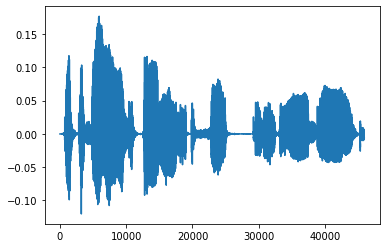

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(source)
plt.show()

from IPython.display import Audio
Audio('spk1_snt1.wav')

Wav2vec2, HuBERT, WavLM and Whisper models are offered as **lobes** in SpeechBrain. Hence, their implementation can be found in:
+ speechbrain.lobes.models.huggingface_wav2vec.py
+ speechbrain.lobes.models.huggingface_whisper.py

Now, we instantiate one of each. It is important to note that in the following example, the returned object are **standard PyTorch Module** as it is almost always the case with SpeechBrain. 

In [ ]:
# BE CAREFUL, IF YOU ARE NOT CONNECTED TO A GPU RUNTIME, THIS WILL CRASH
# THis only happens on Colab, you can of course load models on
from speechbrain.lobes.models.huggingface_wav2vec import HuggingFaceWav2Vec2
from speechbrain.lobes.models.huggingface_whisper import HuggingFaceWhisper

# HuggingFace model hub
model_hub_w2v2 = "facebook/wav2vec2-base-960h"
model_hub_whisper = "openai/whisper-tiny"

model_w2v2 = HuggingFaceWav2Vec2(model_hub_w2v2, save_path='pretrained/')
model_whisper = HuggingFaceWhisper(model_hub_whisper, save_path='pretrained/')

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Here, we can explore the model ...

In [ ]:
print(model_whisper)

HuggingFaceWhisper(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0): WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (final_layer_norm): Lay

Now, we can try to extract audio features from those models! In our examples however, we have two different models that require different forward operations if our goal **solely is to retrieve the latent representation of the audio input.** Wav2vec 2.0 is a transformer encoder, so we just need to get the output of the last layer. Whisper, on the other end, is packaged as a fully trained encoder-decoder. **Hence, we must make sure that we only retrieve the output of the encoder!** 

In [ ]:
source = source.unsqueeze(0)
print(source.shape)

fea_w2v2 = model_w2v2(source)
print(fea_w2v2.shape)

# This can be given as an argument when we instantiate the model as well
model_whisper.encoder_only=True
fea_whisper = model_whisper(source)
print(fea_whisper.shape)

torch.Size([1, 45920])
torch.Size([1, 143, 768])
torch.Size([1, 1500, 384])


**What am I looking at?**

These features correspond to the Context Representation obtained after the transformer (See the *C* in the initial wav2vec2 illustration). Hence, this output dimension is *768* for the Base model (as described in the [paper](https://arxiv.org/abs/2006.11477)). Then, wav2vec2 has an output frequency of 50Hz, and the audio file is 2.87 seconds long explaining the *143* that we obtain in the time dimension. Indeed the shape is [batch, time, features]. The same logic can be applied to Whisper as we obtain the last hidden state of the transformer encoder.

## II. Wav2Vec 2.0 and Whisper encoders as a block of your pipeline (ASR, TIMIT)

Until now, we only saw how to use pretrained wav2vec2 and whisper to infer on a single audio file. Of course, if you just want to do extract features, you could simply loop over your dataset and store everything ... OR you could use SpeechBrain to directly plug those models into your pipeline to compute the features on-the-fly (and fine-tune them!)

In fact, if you are familiar with our YAML formalism (and if you are not, please first check [our tutorial](https://colab.research.google.com/drive/1Pg9by4b6-8QD2iC0U7Ic3Vxq4GEwEdDz?usp=sharing)), HuggingFaceWav2Vec2 and HuggingFaceWhisper can simply be added as a block to your hyperparams file:

For Wav2vec 2.0:
```yaml
wav2vec2: !new:speechbrain.lobes.models.huggingface_wav2vec.HuggingFaceWav2Vec2
    source: !ref <wav2vec2_hub>
    freeze: True
    save_path: !ref <save_folder>/wav2vec2_checkpoint
```

For Whisper:
```yaml
whisper: !new:speechbrain.lobes.models.huggingface_whisper.HuggingFaceWhisper
    pretrained_path: !ref <wav2vec2_url>
    freeze: True
    encoder_only: True
    save_path: !ref <save_folder>/wav2vec2_checkpoint/model.pt
```
- *freeze* enables you to fine-tune (False) or freeze (True) the neural parameters. Note that you can also ask to freeze only the encoder for Whisper or only the feature extractor for wav2vec 2.0. You are left in your pipeline with two PyTorch module objects that can be used as standard layers to propagate your data! 

**After this point you will need basic knowledge about SpeechBrain. Please refer to the prerequisites (at the beginning of this tutorial) if you do not understand something.**

Now, we will dive deeper into the Librispeech ASR (CTC) recipe that can be found [here](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR/CTC).

If you are not familiar with CTC ASR, please refer to our simplified and highly commented [template](https://github.com/speechbrain/speechbrain/tree/develop/templates/speech_recognition/ASR).

In the following section, we will only highlight important parts of the code that are necessary to use the whisper or wav2vec2 models in your recipe!

### Understanding the yaml parameters.

In this setup, we would like to fine-tune the whisper or wav2vec2 models with respect to our dowstream task. More precisely, the architecture of the model is:

```
[ wav -> wav2vec2 or whisper -> Dense ] = encoder
```

To achieve this our YAML file is comprised of different key components (delete the w2v2 references if you are interested by whisper and vice-versa):

```yaml
  [...]

  # URL for the biggest and already fine-tuned english wav2vec2 model and parameters. 
  # URL for the medium whisper as well.
  wav2vec2_hub: "facebook/wav2vec2-large-960h-lv60-self"
  whisper_hub: "openai/whisper-medium"
  freeze_pretrained: False
  lr_pretrained: 0.0001

  [...]

  # The instianciation of the SpeechBrain lobe
  wav2vec2: !new:speechbrain.lobes.models.huggingface_wav2vec.HuggingFaceWav2Vec2
    source: !ref <wav2vec2_hub>
    freeze: !ref <freeze_pretrained>
    save_path: !ref <save_folder>/wav2vec2_checkpoint

  # The instianciation of the SpeechBrain lobe
  whisper: !new:speechbrain.lobes.models.huggingface_whisper.HuggingFaceWhisper
    source: !ref <whisper_hub>
    freeze: !ref <freeze_pretrained>
    encoder_only: True
    save_path: !ref <save_folder>/whisper_checkpoint
  
  # A simple DNN that receive as inputs the output of the pretrained model
  # Here the output dimensionality of the LARGE wav2vec2 and MEDIUM whisper are 1024.
  enc: !new:speechbrain.lobes.models.VanillaNN.VanillaNN
    input_shape: [null, null, 1024]
    activation: !ref <activation>
    dnn_blocks: !ref <dnn_layers>
    dnn_neurons: !ref <dnn_neurons>

  [...]

  # Two optimizers and schedulers to allow:
  # 1. The learning of the encoder and the decoders.
  # 2. Slowly fine-tune only the pretrained (w2v2 or whisper) parts.
  adam_opt_class: !name:torch.optim.AdamW
    lr: !ref <lr>

  pretrained_opt_class: !name:torch.optim.AdamW
    lr: !ref <lr_pretrained>
    
  lr_annealing_adam: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

  lr_annealing_pretrained: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_pretrained>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

  # We add the wav2vec2 / whisper to the modules list so it is uploaded on the GPUs.
  # Remove the one that is not used! 
  modules:
    wav2vec2: !ref <wav2vec2>
    whisper: !ref <whisper>
    enc: !ref <enc>
    emb: !ref <emb>
    dec: !ref <dec>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>

  # We do not add the wav2vec2 / whisper to the model list, so we can apply one optimizer
  # to the randomly initialized model and the other to the pretrained model.
  model: !new:torch.nn.ModuleList
    - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]

  # We add the wav2vec2 /whisper to our checkpointer so the model can be saved!
  checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        wav2vec2: !ref <wav2vec2>
        whisper: !ref <whisper>
        lr_annealing_adam: !ref <lr_annealing_adam>
        lr_annealing_wav2vec: !ref <lr_annealing_wav2vec>
        counter: !ref <epoch_counter>
```

And we combine everything in the python recipe file:

```python
  class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
      [...]
      # The compute forward is strictly identical to any compute_forward method
      # for ASR, except that we just call the wav2vec2 / whisper on the wavs instead of computing acoustic features (FBANKs, MFCCs ...).
      feats = self.modules.wav2vec2(wavs)
      feats = self.modules.whisper(wavs)
      x = self.modules.enc(feats)
      [...]
    
    def init_optimizers(self):
        # Initializes the whisper optimizer and model optimizer. The same can be done for wav2vec2.
        self.pretrained_optimizer = self.hparams.pretrained_opt_class(
            self.modules.whisper.parameters()
        )
        self.adam_optimizer = self.hparams.adam_opt_class(
            self.hparams.model.parameters()
        )
        [...]
    
    def on_stage_end(self, stage, stage_loss, epoch):
        #Gets called at the end of a epoch.
        [...]
        if stage == sb.Stage.VALID:

            # Here we apply our learning_rate annealing on both optimizers
            old_lr_adam, new_lr_adam = self.hparams.lr_annealing_adam(wer)
            old_lr_pretrained, new_lr_pretrained = self.hparams.lr_annealing_pretrained(wer)
            sb.nnet.schedulers.update_learning_rate(
                self.adam_optimizer, new_lr_adam
            )
            sb.nnet.schedulers.update_learning_rate(
                self.pretrained_optimizer, new_lr_wav2vec
            )

    def fit_batch(self, batch):
        # Override of the Brain Class fit_batch function.
        # Managing automatic mixed precision
        [...]
        outputs = self.compute_forward(batch, sb.Stage.TRAIN)

        loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
        loss.backward()

        # Here we manage both optimizers 
        # (Learning enc+dec and Fine-tuning wav2vec2).
        if self.check_gradients(loss):
            self.pretrained_optimizer.step()
            self.adam_optimizer.step()

        self.pretrained_optimizer.zero_grad()
        self.adam_optimizer.zero_grad()

        return loss.detach().cpu()

```

Note: Of course, if you are playing with a frozen wav2vec2 model, no need to employ two different optimizers ;-) And this is it! If you just run your recipe like that, your whisper / wav2vec 2.0 pre-trained encoder will be part of your architecture and be fine-tuned (or not) depending on your requirements. 

## III. Using Whisper as a fully pre-trained encoder-decoder

Whisper is a full transformer. In theory, this means that you could take it and perform zero-shot speech recognition or speech translation. In practice, you most-likely want to fine-tune it on your in-house dataset. Both options can be done within SpeechBrain, and we only need to slightly change our YAML and recipe accordingly. Indeed, we won't need a DNN decoder anymore, as Whisper has one. We won't rely on the CTC loss as well, as the Transformer decoder can be trained with a negative log-likelihood. Finally, we must decide if we want to connect our model to a greedy search decoding or to a more complex beam searcher with or without language model scoring! A summary of what is supported by SpeechBrain for Whisper is:

- Feature extraction
- Encoder fine-tuning
- Encoder-decoder zero shot ASR or ST
- Encoder-decoder fine-tuning
- Greedy decoding
- Beam search decoding with and without LM

Here, we will focus on fine-tuning a base whisper on Librispeech with a greedy decoding. 

To achieve this we must first modify our previous YaML file, and python script. Here, we needs to set the `encoder_only` to `False` because we wants to keeps the decoder. We also needs to integrate a search function that will takes the most probable token predicted by the decoder and feed it back (concatenated with the previous tokens) to the decoder in an auto regressive manner.
Contrary to the previous example, we don't need to add a language modeling head on top of the Whisper decoder because it will be already created for you when you will fetch the Whisper model. Now you have everything needed for fine-tuning the Whisper Encoder-Decoder!


Let's see what happens in practice:



```yaml
  [...]

  whisper_hub: "openai/whisper-medium"
  freeze_pretrained: False
  lr_pretrained: 0.0001

  # we need to specify the language of the inputs audios.
  language: english

  # These values will be used during decoding. 
  # The first one design the first token to be added during searching.
  # The second is the token to stop the expansion of hypotheses that have reached eos.
  timestamp_index: 50363
  eos_index: 50257

  # This value is the ratio of steps during the decoding.
  # e.g, encoded speech is [B, T, F], then the maximal number of steps will be T * max_decode_ratio. 
  max_decode_ratio: 0.5

  [...]

  # The instanciation of the SpeechBrain lobe
  whisper: !new:speechbrain.lobes.models.huggingface_whisper.HuggingFaceWhisper
    source: !ref <whisper_hub>
    freeze: !ref <freeze_pretrained>
    encoder_only: False # :)
    save_path: !ref <save_folder>/whisper_checkpoint

  [...]

  pretrained_opt_class: !name:torch.optim.AdamW
    lr: !ref <lr_pretrained>
    
  lr_annealing_pretrained: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_pretrained>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

  # We add the  whisper to the modules list so it is uploaded on the GPUs.
  modules:
    whisper: !ref <whisper>

  # We creates the searcher method to decode the Whisper model.
  valid_greedy_searcher: !new:speechbrain.decoders.seq2seq.S2SWhisperGreedySearch
    model: !ref <whisper>
    bos_index: !ref <timestamp_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: 0
    max_decode_ratio: !ref <max_decode_ratio>

  # We add the whisper to our checkpointer so the model can be saved!
  checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
   checkpoints_dir: !ref <save_folder>
   recoverables:
      whisper: !ref <whisper>
      scheduler_whisper: !ref <lr_annealing_whisper>
      counter: !ref <epoch_counter>

```

And we combine everything in the python recipe file:

```python
  class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
      wavs, wav_lens = batch.sig
      bos_tokens, bos_tokens_lens = batch.tokens_bos
      
      [...]

      # The compute forward is similar to any compute_forward method for ASR   
      # with Transformers in SpeechBrain.

      # Forward encoder + decoder
      enc_out, logits, _ = self.modules.whisper(wavs, bos_tokens)

      log_probs = self.hparams.log_softmax(logits)

      hyps = None
      if stage != sb.Stage.TRAIN:
          # perform greedy searcher and return the hypotheses found
          hyps, _ = self.hparams.valid_greedy_searcher(enc_out, wav_lens)

      [...]

      return log_probs, hyps, wav_lens

    def compute_objectives(self, predictions, batch, stage):
      log_probs, hyps, wav_lens, = predictions

      tokens_eos, tokens_eos_lens = batch.tokens_eos

      [...]

      # compute the NLL loss
      loss = self.hparams.nll_loss(
            log_probs, tokens_eos, tokens_eos_lens,
        )

      if stage != sb.Stage.TRAIN:
        tokens, tokens_lens = batch.tokens

        # Decode token terms to words
        predicted_words = self.tokenizer.batch_decode(
            hyps, skip_special_tokens=True
        )

        # Convert indices to words
        target_words = undo_padding(tokens, tokens_lens)
        target_words = self.tokenizer.batch_decode(
            target_words, skip_special_tokens=True
        )

        # Compute our metrics
        self.wer_metric.append(ids, predicted_words, target_words)
        self.cer_metric.append(ids, predicted_words, target_words)

        [...]

      return loss
    
 def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:

            old_lr_whisper, new_lr_whisper = self.hparams.lr_annealing_whisper(
                stage_stats["loss"]
            )

            sb.nnet.schedulers.update_learning_rate(
                self.optimizer, new_lr_whisper
            )
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr_whisper": old_lr_whisper},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)
```

With that, you can fine-tune the latest Whisper model on the dataset of your choice!

You can play around with this model and try to improving it with a beam search decoding instead of the greedy search, or you could just scale up and take the largest available whisper model... and everything via SpeechBrain! 

## IV. Current limitations

In fact, there is only one major limitation: the VRAM consumption. Indeed, fine-tuning a wav2vec2 model involves keeping an extremely large amount of parameters in the VRAM (300 Million for Large models). Hence, the VRAM consumption is easily multiplied by a factor of two compared to an equivalent recipe that would use a simpled encoder such as a CRDNN. 




# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```